### Pathway Inclusion
An idea to model the problem including pathway information is to use a bipartite graph in which one set corresponds to the samples and another set corresponds to the genes. A node between those two sets exists if the expression level of that gene in the sample is bigger than a threshold $t_e$. The pathway information could be added by connecting gene nodes with each other that contribute to the same pathway based on data from string-db.org. The node is added if the score of this connection is bigger than a threshold $t_p$.

In [1]:
% load_ext autoreload
% autoreload 2
import sys
sys.path.append('..')
import os
import networkx as nx
import json
from src.data.load_data import get_small_dataset_content, get_big_dataset_content
from src.features.download import get_string_db_identifier, get_associated_genes, save_associated_genes
from src.features.normalize import select_variance_features, scale_df
from src.features.download import load_associated_genes
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict

In [2]:
df, labels = get_big_dataset_content()

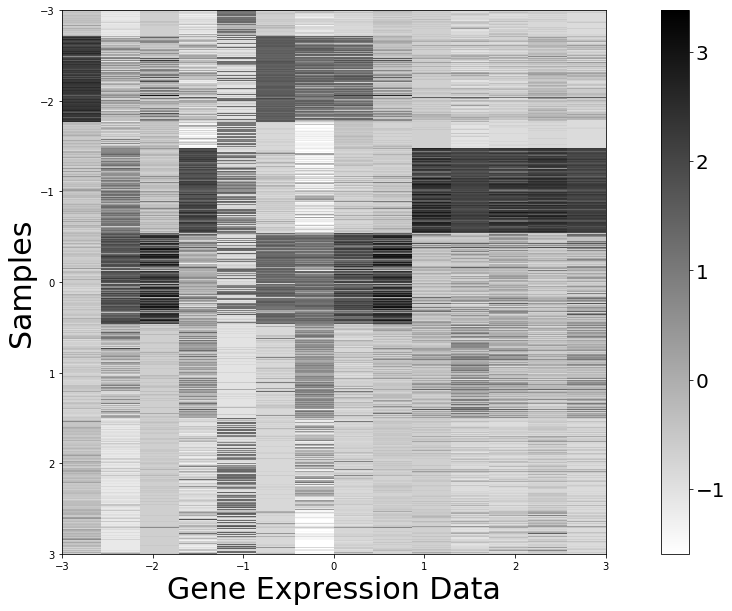

In [3]:
plt.figure(figsize=(20,10))
im = plt.imshow(df, extent=(-3, 3, 3, -3), cmap='binary')
plt.ylabel("Samples", fontsize=30)
plt.xlabel("Gene Expression Data", fontsize=30)
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=20)
plt.show()

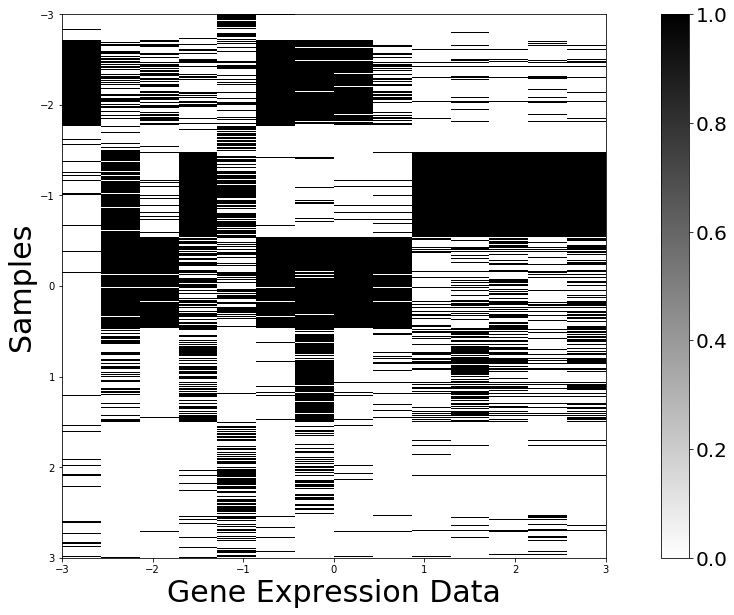

In [4]:
plt.figure(figsize=(20,10))
im = plt.imshow(df>0, extent=(-3, 3, 3, -3), cmap='binary')
plt.ylabel("Samples", fontsize=30)
plt.xlabel("Gene Expression Data", fontsize=30)
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=20)
plt.show()

In [5]:
def find_cliques(graph):
    p = set(graph.keys())
    r = set()
    x = set()
    cliques = []
    for v in degeneracy_ordering(graph):
        neighs = graph[v]
        find_cliques_pivot(graph, r.union([v]), p.intersection(neighs), x.intersection(neighs), cliques)
        p.remove(v)
        x.add(v)
    return sorted(cliques, lambda x: len(x))


def find_cliques_pivot(graph, r, p, x, cliques):
    if len(p) == 0 and len(x) == 0:
        cliques.append(r)
    else:
        u = iter(p.union(x)).next()
        for v in p.difference(graph[u]):
            neighs = graph[v]
            find_cliques_pivot(graph, r.union([v]), p.intersection(neighs), x.intersection(neighs), cliques)
            p.remove(v)
            x.add(v)


def degeneracy_ordering(graph):
    ordering = []
    ordering_set = set()
    degrees = defaultdict(lambda: 0)
    degen = defaultdict(list)
    max_deg = -1
    for v in graph:
        deg = len(graph[v])
        degen[deg].append(v)
        degrees[v] = deg
        if deg > max_deg:
            max_deg = deg

    while True:
        i = 0
        while i <= max_deg:
            if len(degen[i]) != 0:
                break
            i += 1
        else:
            break
        v = degen[i].pop()
        ordering.append(v)
        ordering_set.add(v)
        for w in graph[v]:
            if w not in ordering_set:
                deg = degrees[w]
                degen[deg].remove(w)
                if deg > 0:
                    degrees[w] -= 1
                    degen[deg - 1].append(w)

    ordering.reverse()
    return ordering

def bronker_bosch2(all_cliques, clique, candidates, excluded):
    '''Bron–Kerbosch algorithm with pivot'''
    if not candidates and not excluded:
        if len(clique) >= MIN_SIZE:
            all_cliques.append(clique)
        return all_cliques
 
    pivot = pick_random(candidates) or pick_random(excluded)
    for v in list(candidates.difference(NEIGHBORS[pivot])):
        new_candidates = candidates.intersection(NEIGHBORS[v])
        new_excluded = excluded.intersection(NEIGHBORS[v])
        bronker_bosch2(all_cliques, clique + [v], new_candidates, new_excluded)
        candidates.remove(v)
        excluded.add(v)
    return all_cliques


def pick_random(s):
    if s:
        elem = s.pop()
        s.add(elem)
        return elem

In [6]:
df.head()

,ENSG00000042832,ENSG00000086548,ENSG00000122852,ENSG00000128422,ENSG00000129824,ENSG00000136352,ENSG00000157765,ENSG00000168878,ENSG00000185303,ENSG00000185479,ENSG00000186081,ENSG00000186832,ENSG00000186847,ENSG00000205420
sample_id,,,,,,,,,,,,,,
0,-0.390651,-0.874771,-0.651031,-1.326890,1.105814,-0.671635,-1.117481,-0.721843,-0.475640,-0.571603,-0.078680,-0.932995,-0.821309,-0.701825
1,-0.546451,-1.045201,-0.651031,-0.846695,1.272846,-0.826816,-0.570226,-0.758942,-0.726717,-0.678175,-1.041723,-0.365608,-0.821309,-0.884311
2,-0.294704,-0.334087,-0.651031,-0.901615,1.147219,0.153893,-0.745637,-0.686860,-0.619298,-0.537545,-0.612176,-0.795993,-0.821309,-0.762039
3,-0.368586,-1.044671,-0.651031,-0.009298,-0.160563,-0.664179,-0.352765,-0.758210,-0.557765,-0.678175,0.419710,-0.104387,-0.648623,-0.032136
4,-0.387323,-1.161929,-0.651031,-1.273913,-0.192725,-0.826816,-1.023866,-0.765135,-0.156699,-0.678175,-0.226191,-0.932995,-0.821309,-0.770710


A sample node $n_s$ has a gene neighbor $n_g$ if the expression of that gene in the sample is bigger than $\tau_e$.

In [7]:
NEIGHBORS = [[]] # I want to start index from 1 instead of 0
TAU_E = 0
gene_neighbor_id_map = {}
# Build from first set of vertices (samples)
for row_index, row in df.iterrows():
    sample_neighbors = []
    for column, item in row.iteritems():
        if item > TAU_E:
            if column not in gene_neighbor_id_map.keys():
                gene_neighbor_id_map[column] = len(df) + 1 + list(row.index).index(column)
            sample_neighbors.append(gene_neighbor_id_map[column])
    NEIGHBORS.append(sample_neighbors)

# Build from second set of vertices (samples)
for _ in df.columns:
    NEIGHBORS.append([])

In [8]:
# Find maximal cliques on bipartite graph without biological context
MIN_SIZE = 2
NODES = set(range(1, len(NEIGHBORS)))
bronker_bosch2([], [], set(NODES), set())[:10]

[[1, 3194],
 [2, 3194],
 [3, 3194],
 [3, 3195],
 [4, 3200],
 [6, 3194],
 [6, 3195],
 [7, 3194],
 [9, 3194],
 [13, 3194]]

In [9]:
assert len(NEIGHBORS) == len(df) + len(df.columns) + 1
gene_neighbors = NEIGHBORS[-len(df.columns):]
assert len(gene_neighbors) == len(df.columns)
for x in gene_neighbors:
    assert len(x) == 0

We now need to interconnect the vertices of the gene set. Two gene nodes $n_{g1}$ and $n_{g2}$ are connected if their estimated interconnectivity given by the db_score of the StringDB database is higher than $\tau_i$.

In [10]:
def get_df_associations_from_score(df, tau=0.5, score_name='dscore', make_symmetric=True):
    """Return a DataFrame of size n_columns x n_columns. Cell with index i, j is set to 1 if gene i shows a higher
    confidence of an interactions with gene j based on score score_name"""
    df_associations = pd.DataFrame(index=df.columns, columns=df.columns)
    df_associations = df_associations.fillna(0)
    # Show from identifier in column to identifier used by StringDB
    identifier_map = {}
    for identifier in df.columns:
        path = os.path.join('../data/external', "{}.json".format(identifier))
        string_db_id = json.load(open(path))["identifier"]
        identifier_map[identifier] = string_db_id

    for gene in df.columns:
        associated_genes = load_associated_genes(identifier=gene)
        for associated_gene in associated_genes:
            if associated_gene[score_name] > TAU_I:
                associated_gene_name = associated_gene["stringId"]
                if associated_gene_name in identifier_map.keys() or associated_gene_name in identifier_map.values():
                    # Associated gene name to column gene name
                    for column_gene_id, string_gene_id in identifier_map.items():
                        if associated_gene_name == string_gene_id:
                            associated_gene_name = column_gene_id
                            break
                    # Search the associated gene name in the identifiers map
                    for column_gene_id, string_gene_id in identifier_map.items():
                        if column_gene_id == associated_gene_name:
                            df_associations.loc[gene, associated_gene_name] = 1
                            break
    if make_symmetric:
        for index, row in df_associations.iterrows():
            for col in df_associations.columns:
                if row.get(col) == 1:
                    df_associations.loc[col, index] = 1
            
        # Matrix should be symmtric
        assert np.allclose(df_associations, df_associations.T, atol=1e-8)
        # not the case since ENSG00000186847 (ENSP00000167586) doesnt contain ENSG00000128422 (ENSP00000308452) nor ENSG00000186832 (ENSP00000301653) but vice versa is the case
    return df_associations

TAU_I = 0.5
df_associations = get_df_associations_from_score(df, TAU_I, 'dscore')
df_associations

,ENSG00000042832,ENSG00000086548,ENSG00000122852,ENSG00000128422,ENSG00000129824,ENSG00000136352,ENSG00000157765,ENSG00000168878,ENSG00000185303,ENSG00000185479,ENSG00000186081,ENSG00000186832,ENSG00000186847,ENSG00000205420
ENSG00000042832,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000086548,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000122852,0,0,0,0,0,0,0,1,1,0,0,0,0,0
ENSG00000128422,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000129824,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000136352,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000157765,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000168878,0,0,1,0,0,0,0,0,1,0,0,0,0,0
ENSG00000185303,0,0,1,0,0,0,0,1,0,0,0,0,0,0
ENSG00000185479,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
NEIGHBORS = [[]] # I want to start index from 1 instead of 0
gene_neighbor_id_map = {}
naive_graph = nx.Graph()
# Build from first set of vertices (samples)
for row_index, row in df.iterrows():
    sample_neighbors = []
    for column, item in row.iteritems():
        if item > TAU_E:
            if column not in gene_neighbor_id_map.keys():
                gene_neighbor_id_map[column] = len(df) + 1 + list(row.index).index(column)
                naive_graph.add_edge(row_index, column)
            sample_neighbors.append(gene_neighbor_id_map[column])
    NEIGHBORS.append(sample_neighbors)

# Build from second set of vertices (samples)
for col_index, gene in enumerate(df.columns):
    gene_neighbors = []
    for associated_gene in df_associations.columns:
        if df_associations.loc[gene, associated_gene] == 1:
            gene_neighbors.append(gene_neighbor_id_map[associated_gene])
            naive_graph.add_edge(gene, associated_gene)
    NEIGHBORS.append(gene_neighbors)

In [13]:
assert len(NEIGHBORS) == len(df) + len(df.columns) + 1
gene_neighbors = NEIGHBORS[-len(df.columns):]
assert len(gene_neighbors) == len(df.columns)

In [14]:
MIN_SIZE = 3
NODES = set(range(1, len(NEIGHBORS)))
cliques = bronker_bosch2([], [], set(NODES), set())
cliques[:20]

[[120, 3192, 3198],
 [156, 3192, 3197],
 [161, 3192, 3197, 3198],
 [162, 3192, 3197],
 [163, 3192, 3197, 3198],
 [164, 3192, 3197],
 [171, 3192, 3197, 3198],
 [174, 3192, 3197],
 [176, 3192, 3197],
 [177, 3192, 3197, 3198],
 [178, 3192, 3197, 3198],
 [179, 3192, 3197],
 [184, 3192, 3197],
 [185, 3192, 3197, 3198],
 [191, 3192, 3197, 3198],
 [193, 3192, 3197],
 [194, 3192, 3197],
 [196, 3192, 3198],
 [198, 3192, 3197],
 [199, 3192, 3197]]

In [15]:
""" Build the dict that maps from gene ids to nodes in the cluster"""
bicluster_dict = {}
for clique in cliques:
    sample_id = clique.pop(0)
    key = []
    for row_index in clique:
        key.append(df_associations.iloc[row_index-len(df)-1].name)
    key = ','.join(key)
    if key not in bicluster_dict.keys():
        bicluster_dict[key] = [sample_id]
    else:
        bicluster_dict[key].append(sample_id)

In [16]:
def get_our_identifier(identifier_map, ensemble_identifier):
    for k, v in identifier_map.items():
        if v == ensemble_identifier:
            return k

identifier_map = {}
for identifier in df.columns:
    path = os.path.join('../data/external', "{}.json".format(identifier))
    string_db_id = json.load(open(path))["identifier"]
    identifier_map[identifier] = string_db_id
    
protein_to_gene_map = {v: k for k, v in identifier_map.items()}
    
recall_count = 0

scores = ['ascore', 'dscore', 'escore', 'fscore', 'nscore', 'pscore', 'score', 'tscore']
evaluation_precision = pd.DataFrame(columns=scores, index=scores)
evaluation_precision.fillna(0., inplace=True)
evaluation_recall = evaluation_precision.copy()
evaluation_counts = evaluation_precision.copy()

for score_name in scores:
    print("Building based on {}".format(score_name))
    df_associations = get_df_associations_from_score(df, tau=TAU_I, score_name=score_name, make_symmetric=True)
    
    NEIGHBORS = [[]] # I want to start index from 1 instead of 0
    TAU_E = 0
    TAU_I = 0
    gene_neighbor_id_map = {}
    # Build from first set of vertices (samples)
    for row_index, row in df.iterrows():
        sample_neighbors = []
        for column, item in row.iteritems():
            if item > TAU_E:
                if column not in gene_neighbor_id_map.keys():
                    gene_neighbor_id_map[column] = len(df) + 1 + list(row.index).index(column)
                sample_neighbors.append(gene_neighbor_id_map[column])
        NEIGHBORS.append(sample_neighbors)

    # Build from second set of vertices (genes)
    for col_index, gene in enumerate(df.columns):
        gene_neighbors = []
        for associated_gene in df_associations.columns:
            if df_associations.loc[gene, associated_gene] == 1:
                gene_neighbors.append(gene_neighbor_id_map[associated_gene])
        NEIGHBORS.append(gene_neighbors)
        
    MIN_SIZE = 3
    NODES = set(range(1, len(NEIGHBORS)))
    
    cliques = bronker_bosch2([], [], set(NODES), set())
    bicluster_dict = {}
    for clique in cliques:
        sample_id = clique.pop(0)
        key = []
        for row_index in clique:
            key.append(df_associations.iloc[row_index-len(df)-1].name)
        key = ','.join(key)
        if key not in bicluster_dict.keys():
            bicluster_dict[key] = [sample_id]
        else:
            bicluster_dict[key].append(sample_id)
    
    for score_compared in scores:
        for cluster in bicluster_dict.keys():
            cluster_genes = set(map(lambda x : identifier_map[x], cluster.split(',')))
            associated_genes = set()
            for cluster_gene in cluster_genes:
                #our_identifier = get_our_identifier(identifier_map, cluster_gene)
                #path = os.path.join('../data/external', "{}.json".format(our_identifier))
                #gene_dict = json.load(open(path))
                #for entry in gene_dict["data"]:
                #    if entry[score_compared] > TAU_I:
                #        associated_genes.add(entry["stringId"])
                for other_cluster_gene in list(set(cluster_genes) - set([cluster_gene])):
                    a = protein_to_gene_map[cluster_gene]
                    b = protein_to_gene_map[other_cluster_gene]
                    if df_associations.loc[a, b] != 1:
                        print("Cluster {}: {} is not associated with {} based on {}".format(cluster, a, b, score_compared))
            tp = cluster_genes & associated_genes
            fp = cluster_genes - associated_genes
            if len(cluster_genes & associated_genes) < len(cluster_genes):
                pass
                #print("Based on {}, compared against {}:".format(score_name, score_compared))
                #print(cluster_genes)
                #print(associated_genes)
            if len(tp) + len(fp) > 0:
                precision = len(tp)/float(len(tp) + len(fp))
                evaluation_precision[score_name][score_compared] += precision
            if len(associated_genes) > 0:
                recall = len(tp)/len(associated_genes)
                recall_count += 1
                recall = len(tp)/len(associated_genes)
                evaluation_recall[score_name][score_compared] += recall
            evaluation_counts[score_name][score_compared] += 1

# Normalize metrics
evaluation_precision = evaluation_precision.div(evaluation_counts)
evaluation_precision.fillna(0, inplace=True)
evaluation_recall = evaluation_recall / recall_count

Building based on ascore
Building based on dscore
Building based on escore
Building based on fscore
Building based on nscore
Building based on pscore
Building based on score
Building based on tscore


In [17]:
evaluation_recall

,ascore,dscore,escore,fscore,nscore,pscore,score,tscore
ascore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dscore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
escore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fscore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nscore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pscore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tscore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


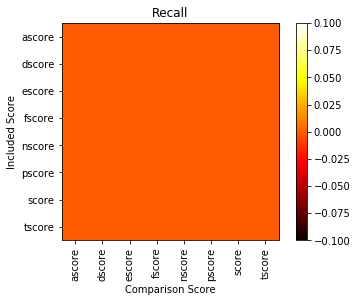

In [18]:
plt.imshow(evaluation_recall.fillna(0), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(scores)), scores,rotation='vertical')
plt.yticks(range(len(scores)), scores)
plt.xlabel("Comparison Score")
plt.ylabel("Included Score")
plt.title("Recall")
plt.show()

In [19]:
evaluation_precision

,ascore,dscore,escore,fscore,nscore,pscore,score,tscore
ascore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dscore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
escore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fscore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nscore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pscore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tscore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


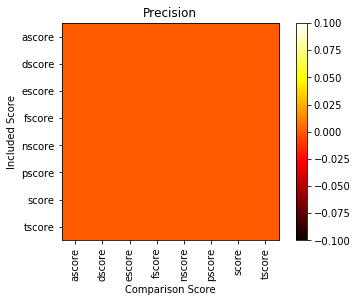

In [20]:
plt.imshow(evaluation_precision.fillna(0), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(scores)), scores,rotation='vertical')
plt.yticks(range(len(scores)), scores)
plt.xlabel("Comparison Score")
plt.ylabel("Included Score")
plt.title("Precision")
plt.show()

In [21]:
# Add more metrics from 1.1 like F-score, how well clusters are built
# Look into clusters: is there one gen that belongs to two clusters while the gens in both clusters
# belong to two disjoint biological processes?

In [22]:
#Based on ascore, compared against ascore:
#Genes have been found to be associated, even though they aren't connected via the ascore
#'ENSP00000252242', 'ENSP00000308452': Keratin 5, Keratin 17
#The gene expression cluster defining basal epithelial cells included keratin 5, keratin 17, integrin-β4, and laminin ...
#https://www.sciencedirect.com/science/article/pii/B9780128021019000326

In [23]:
# Evaluation: Problem - What is the ground truth for the x-axis (genes)?
#                       When using precision / recall, there are more than just one class to consider.
#                       -> How to decide what's the primary class of the cluster?
#                       --> Calculate KL-Divergence for testing purposes
#                       --> Assume the class with the most items in the cluster as cluster class

In [24]:
from scipy.stats import entropy

# {'ENSG00000042832,ENSG00000136352': [158, 161, ...], ...}
cluster_scores = []
for cluster_genes, cluster_values in bicluster_dict.items():
    # How 'unpure' is the cluster with respect to the labels of the rows?
    # Compute the Kullback-Leibler divergence between the purest possible cluster and the respective one
    cluster_element_labels = defaultdict(lambda: 0)
    for cv in cluster_values:
        try:
            label = labels[cv]
        except:
            continue
        cluster_element_labels[label] += 1
    purest_distribution = [0] * len(cluster_element_labels)
    purest_distribution[0] = sum(cluster_element_labels.values())
    current_distribution = sorted(list(cluster_element_labels.values()), reverse=True)
    cluster_scores.append([entropy(purest_distribution, list(cluster_element_labels.values())), purest_distribution, current_distribution])

In [25]:
cluster_scores.sort(key=lambda x: x[0])

In [26]:
for score, optimal, current in cluster_scores:
    print("Score: {} Optimal: {} Current: {}".format(score, optimal, current))

Score: 0.0 Optimal: [1] Current: [1]
Score: 0.0 Optimal: [2] Current: [2]
Score: 0.0 Optimal: [9] Current: [9]
Score: 0.0 Optimal: [1] Current: [1]
Score: 0.0 Optimal: [1] Current: [1]
Score: 0.0 Optimal: [1] Current: [1]
Score: 0.0 Optimal: [1] Current: [1]
Score: 0.0 Optimal: [2] Current: [2]
Score: 0.0 Optimal: [1] Current: [1]
Score: 0.0 Optimal: [1] Current: [1]
Score: 0.0 Optimal: [1] Current: [1]
Score: 0.0 Optimal: [2] Current: [2]
Score: 0.0 Optimal: [2] Current: [2]
Score: 0.0 Optimal: [1] Current: [1]
Score: 0.0 Optimal: [1] Current: [1]
Score: 0.030305349495328843 Optimal: [134, 0] Current: [130, 4]
Score: 0.0870113769896299 Optimal: [12, 0] Current: [11, 1]
Score: 0.16705408466316624 Optimal: [13, 0] Current: [11, 2]
Score: 0.20067069546215105 Optimal: [11, 0, 0] Current: [9, 1, 1]
Score: 0.24116205681688804 Optimal: [14, 0] Current: [11, 3]
Score: 0.3930425881096072 Optimal: [40, 0, 0, 0] Current: [27, 7, 5, 1]
Score: 0.4054651081081644 Optimal: [3, 0] Current: [2, 1]
Sco

In [27]:
# Check ensemble protein and gene identifiers
# map pathways to cluster

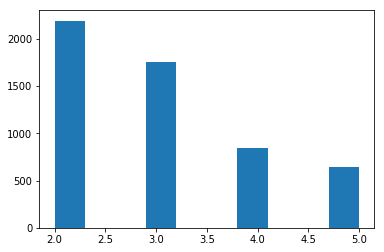

In [28]:
plt.hist(list(map(lambda x : len(x), cliques)), align='mid')
plt.show()

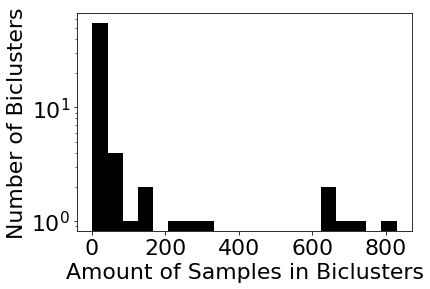

In [49]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt.xlabel("Amount of Samples in Biclusters")
plt.ylabel("Number of Biclusters")
plt.hist(list(map(lambda x : len(x[1]), bicluster_dict.items())), bins=20, color='black', log=True)
plt.show()

ENSG00000186832,ENSG00000128422,ENSG00000186847,ENSG00000205420,ENSG00000185479 12


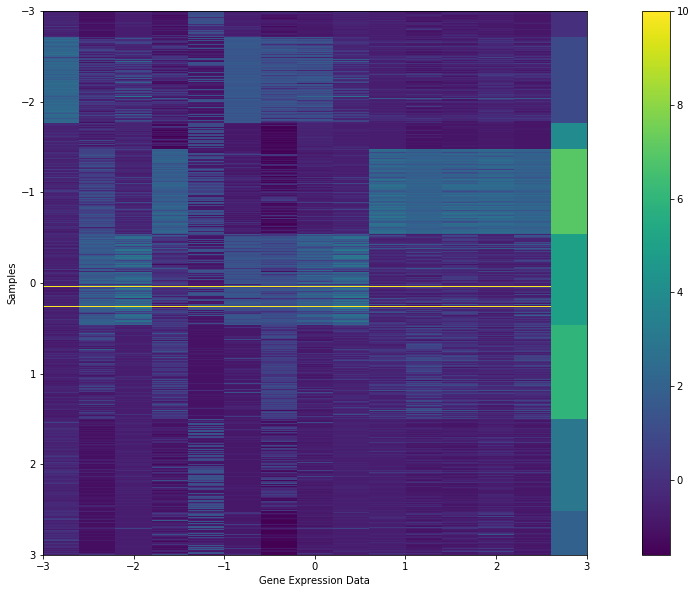

ENSG00000186832,ENSG00000128422,ENSG00000205420,ENSG00000185479 39


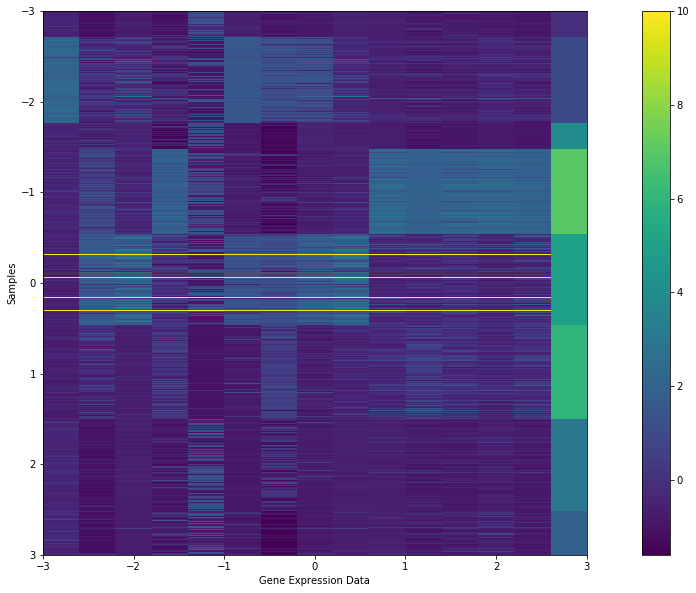

ENSG00000186081,ENSG00000128422,ENSG00000186832 139


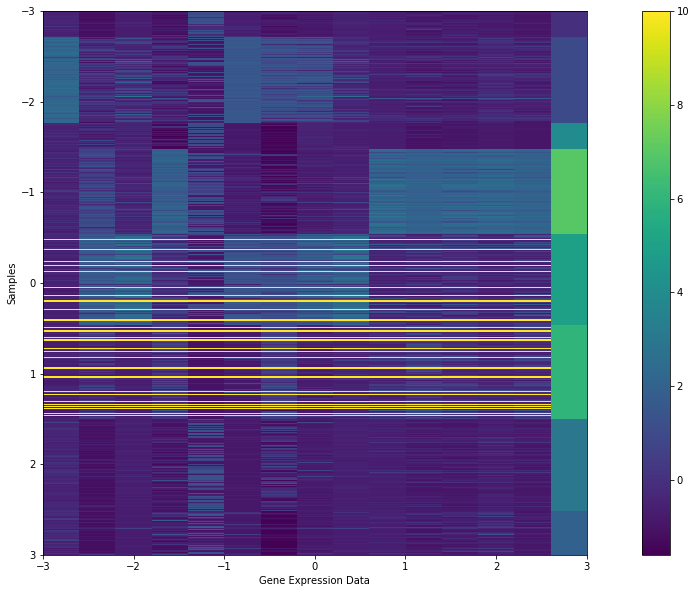

ENSG00000122852,ENSG00000157765 26


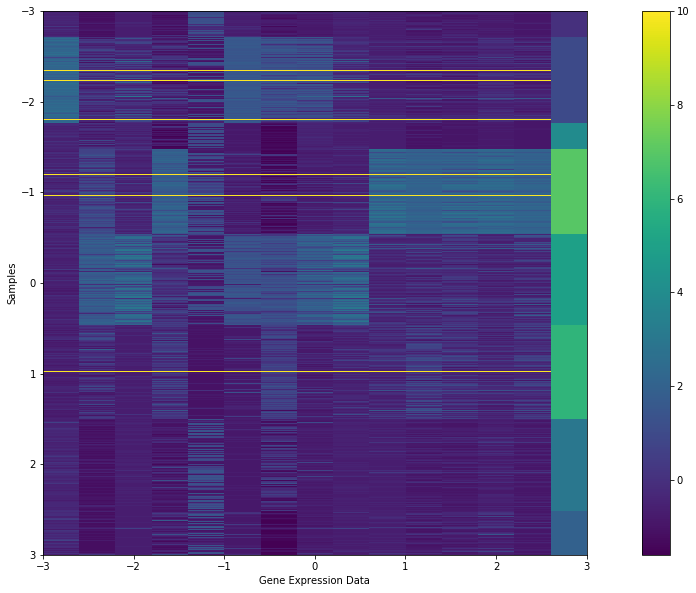

ENSG00000122852,ENSG00000168878,ENSG00000185303 48


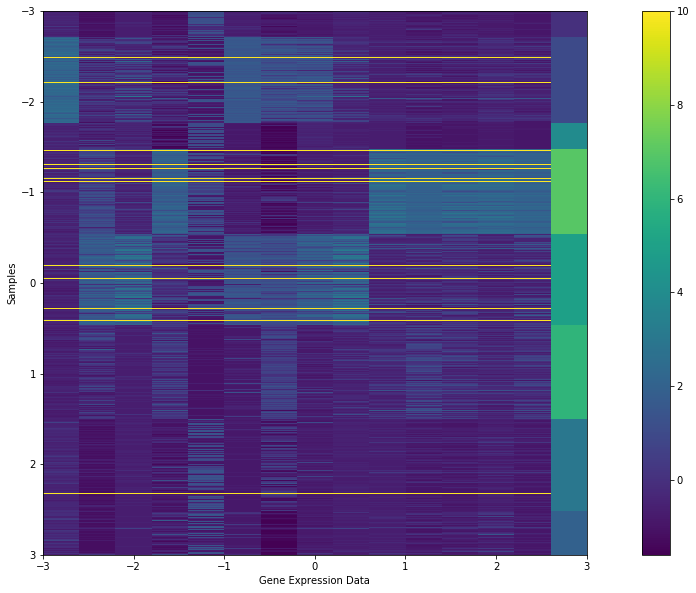

ENSG00000122852,ENSG00000157765,ENSG00000168878 708


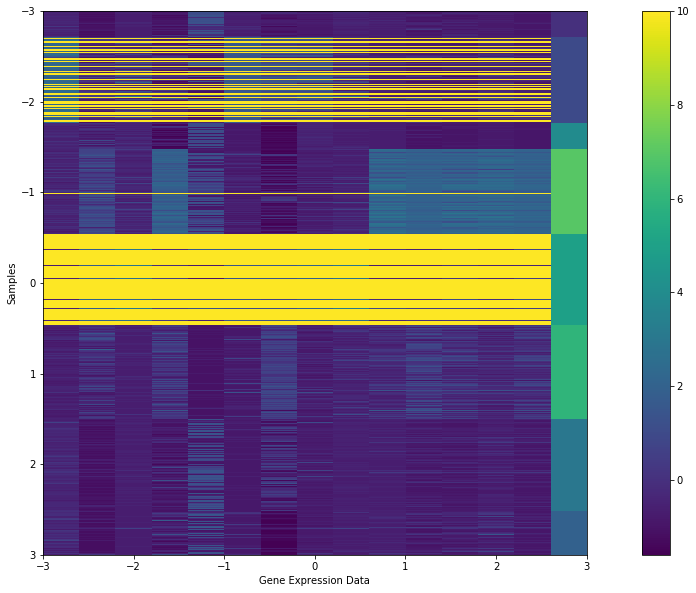

ENSG00000205420,ENSG00000128422,ENSG00000186832 52


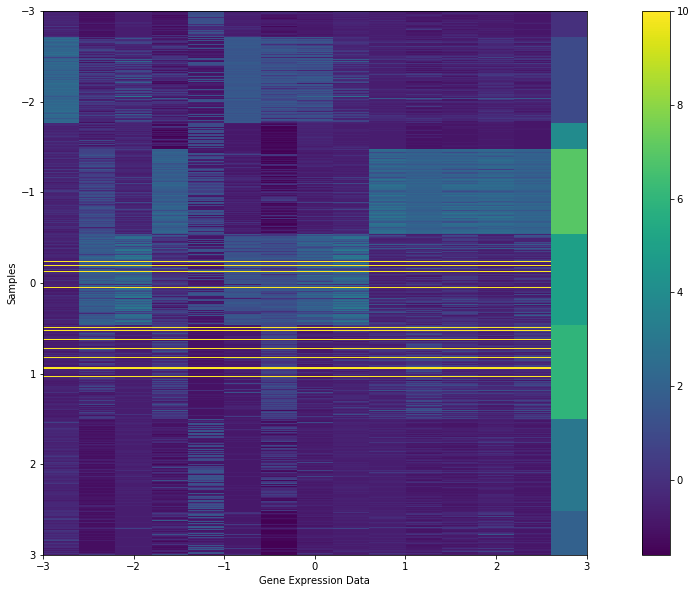

ENSG00000186081,ENSG00000128422 112


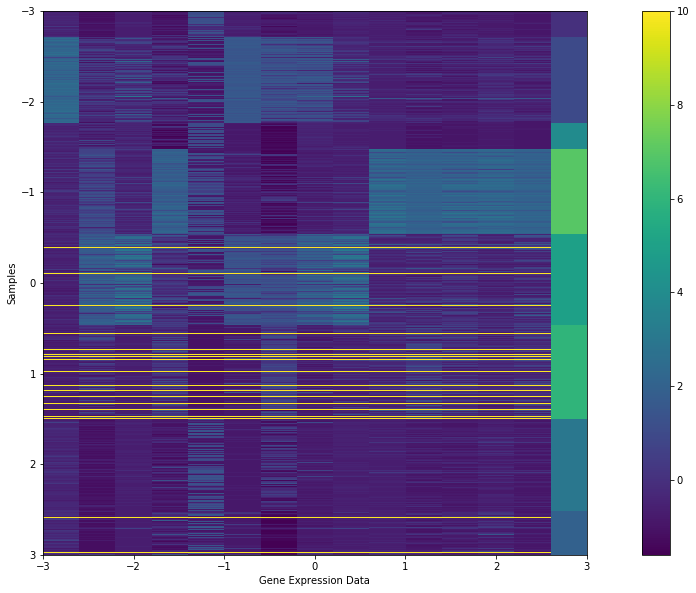

ENSG00000205420,ENSG00000128422,ENSG00000186847 12


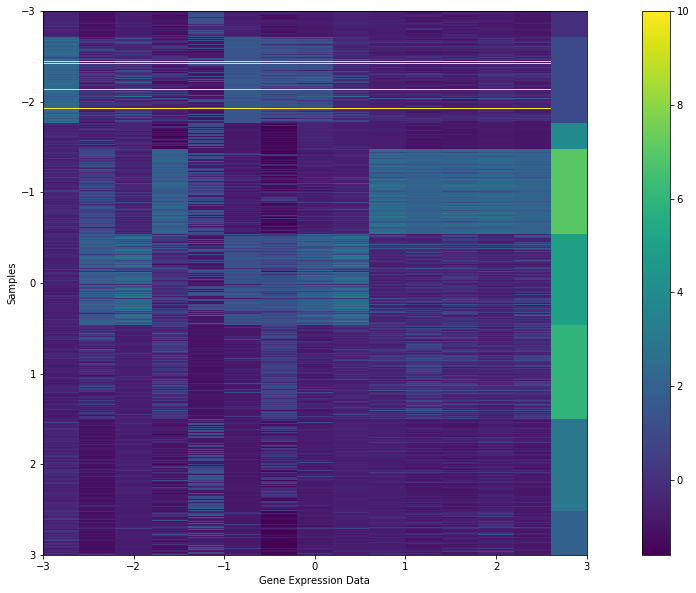

ENSG00000122852,ENSG00000185303 33


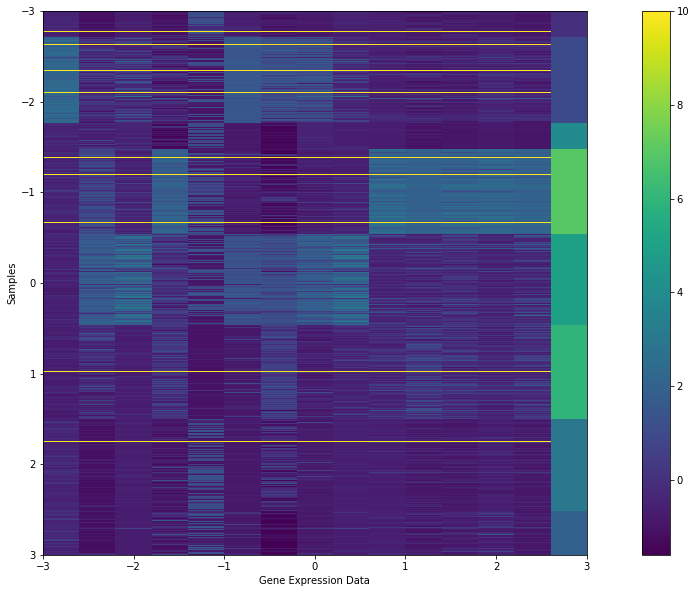

ENSG00000168878,ENSG00000185303 11


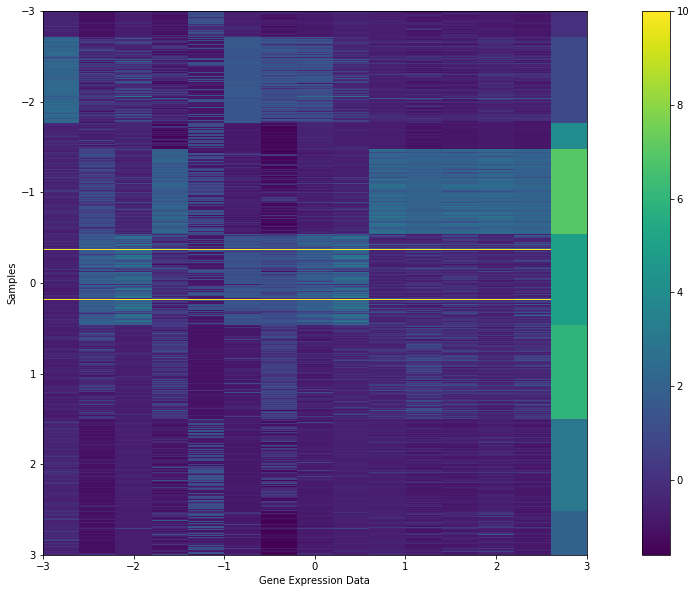

ENSG00000205420,ENSG00000128422,ENSG00000186832,ENSG00000186847,ENSG00000185479 628


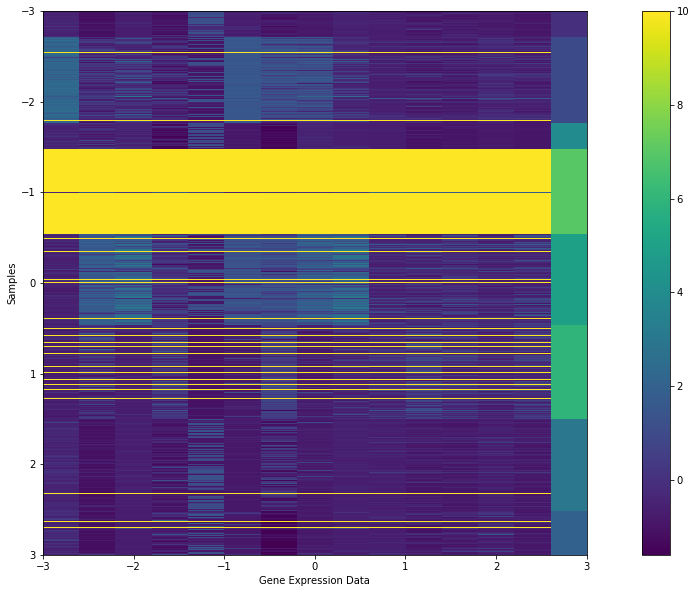

ENSG00000205420,ENSG00000186832,ENSG00000185479 11


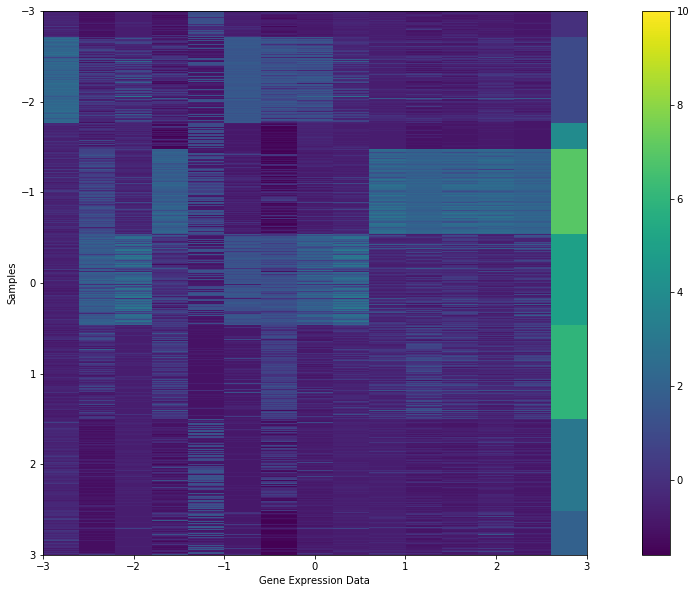

ENSG00000205420,ENSG00000128422,ENSG00000186832,ENSG00000186847 40


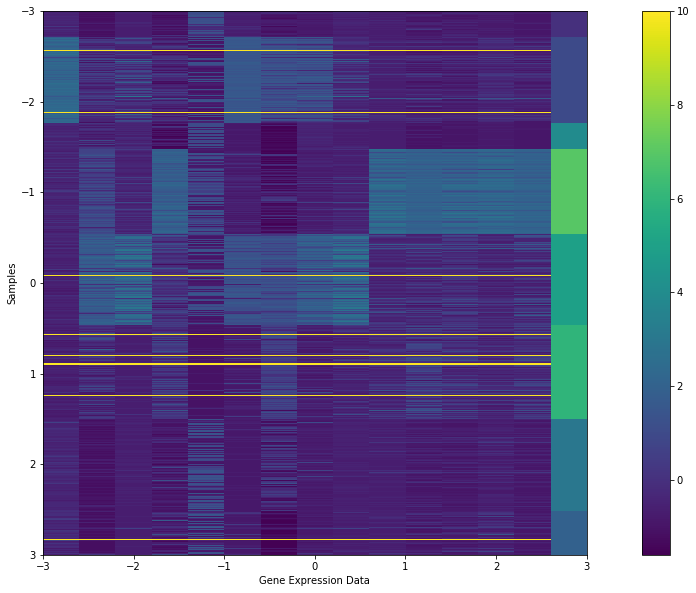

ENSG00000205420,ENSG00000128422,ENSG00000186832,ENSG00000185479 47


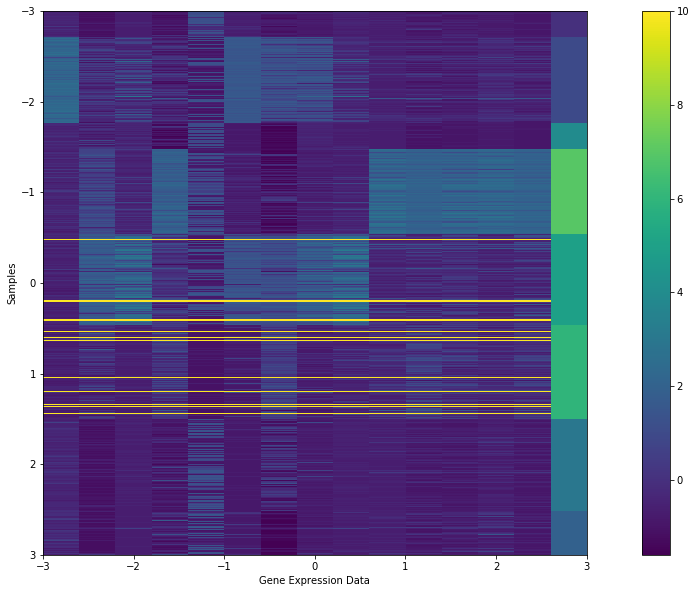

ENSG00000205420,ENSG00000128422,ENSG00000185479 14


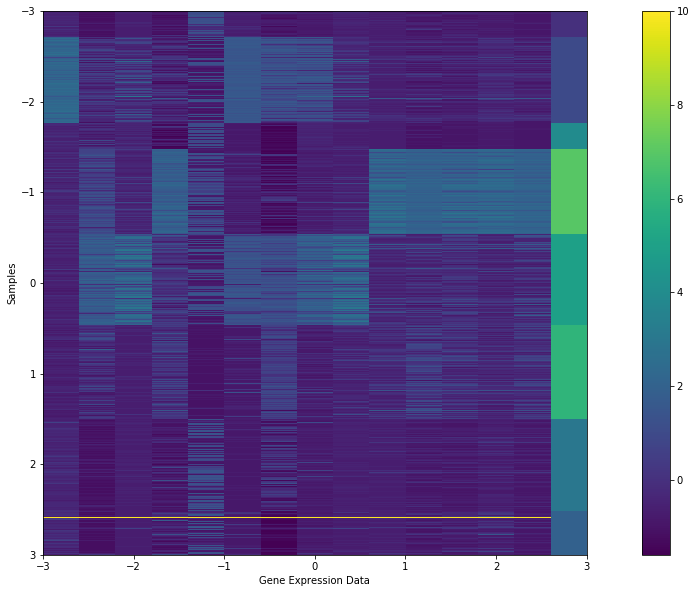

ENSG00000042832,ENSG00000136352 294


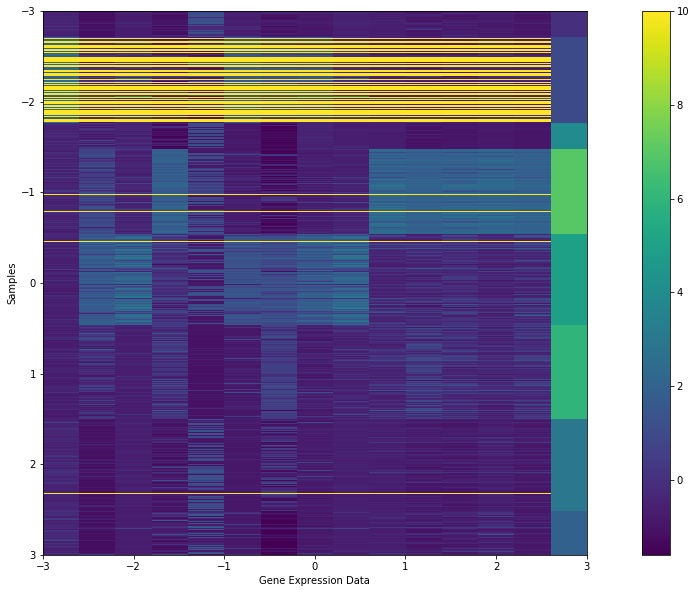

ENSG00000186832,ENSG00000186847 12


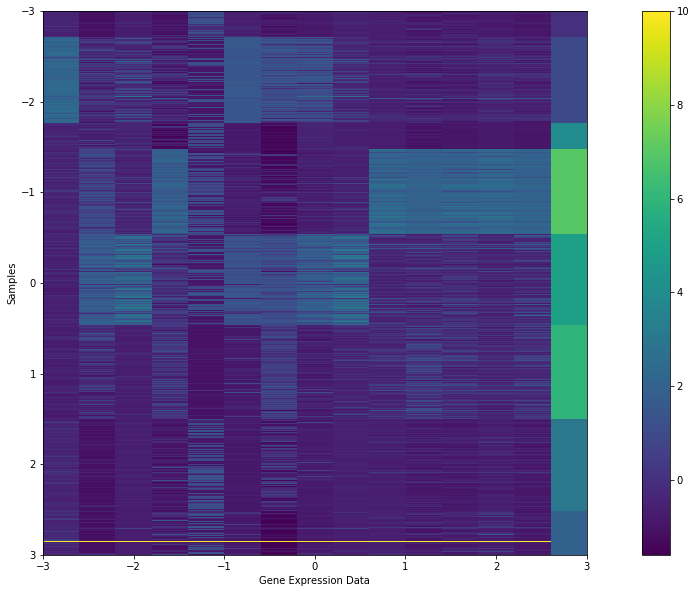

ENSG00000186081,ENSG00000128422,ENSG00000186832,ENSG00000186847 678


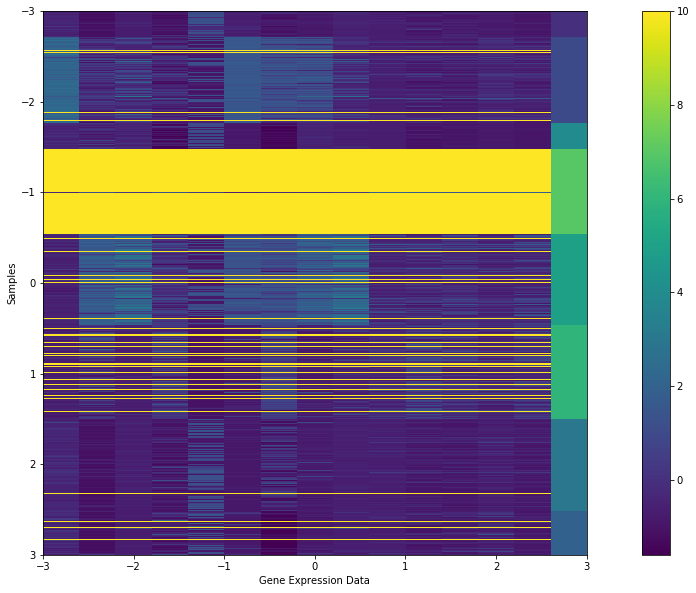

ENSG00000186081,ENSG00000186832,ENSG00000186847 18


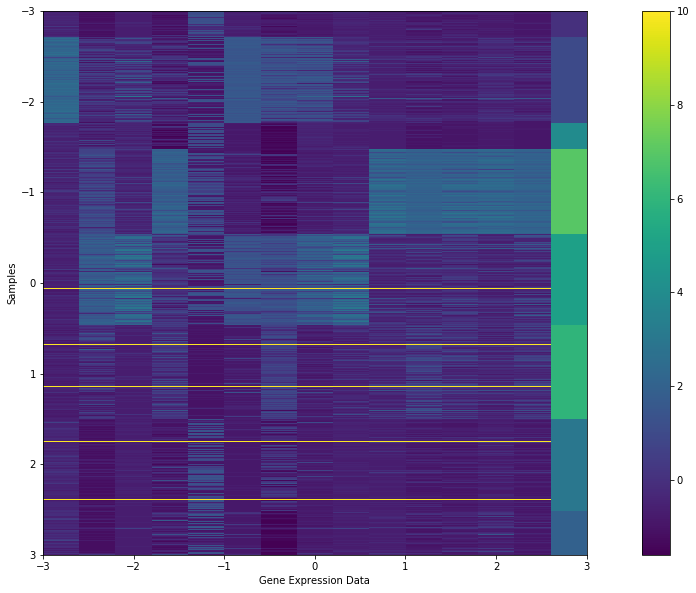

ENSG00000205420,ENSG00000186832 14


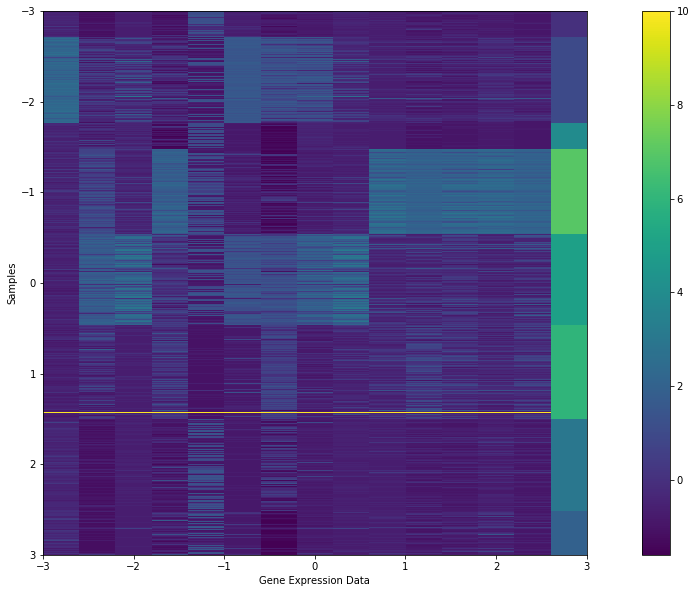

ENSG00000186832,ENSG00000205420 19


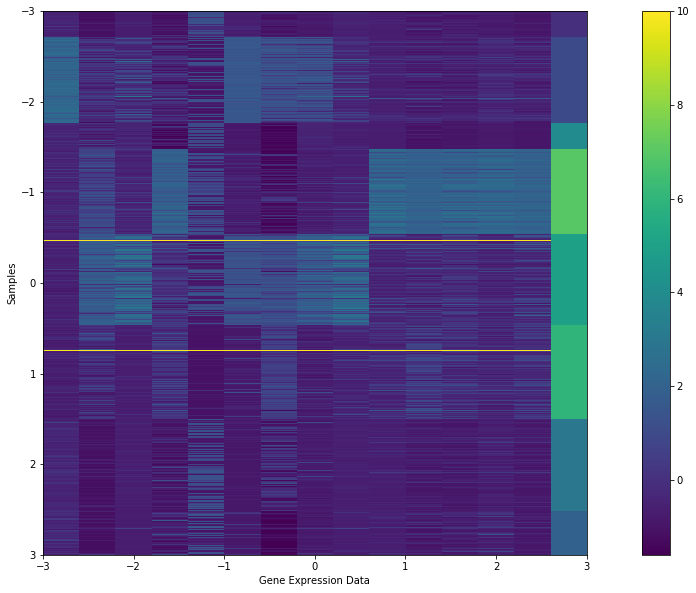

ENSG00000168878,ENSG00000136352 134


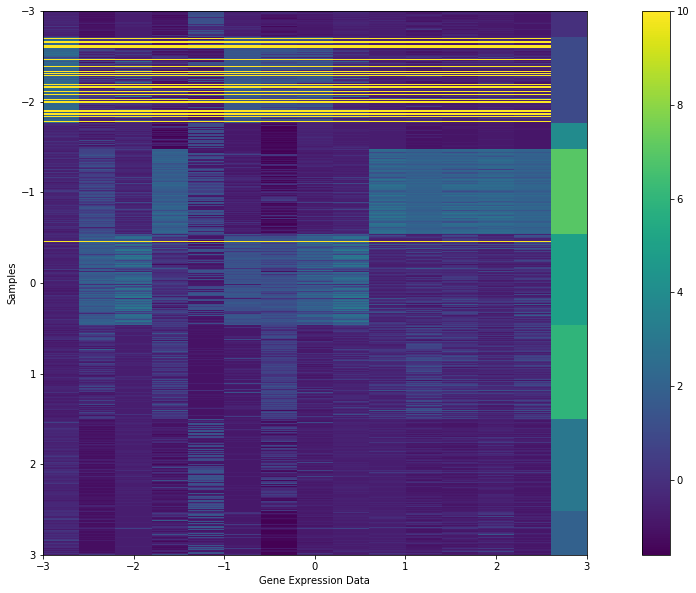

ENSG00000186832,ENSG00000128422 29


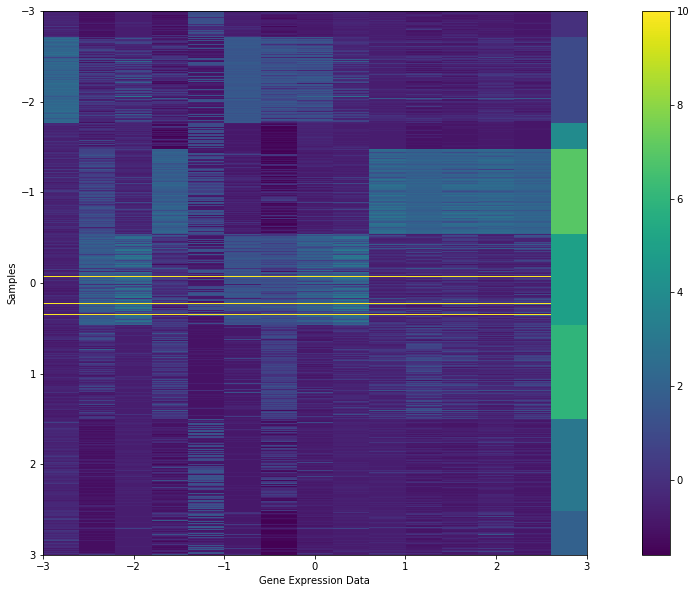

ENSG00000186081,ENSG00000186847 21


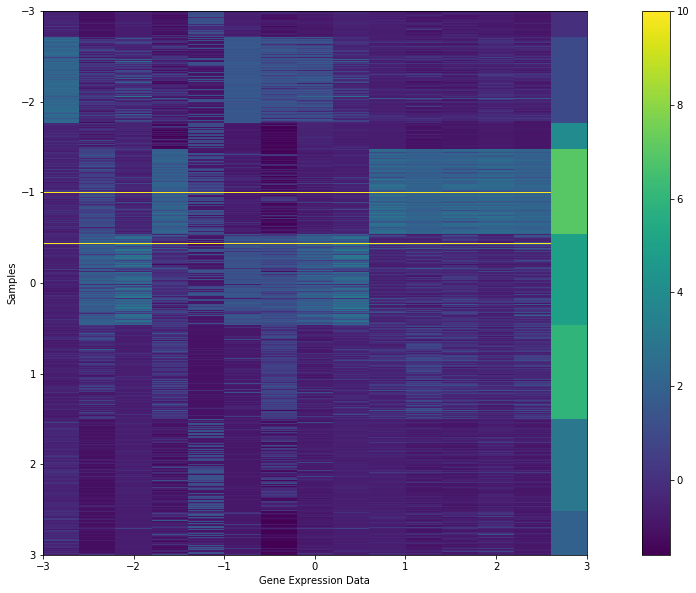

ENSG00000205420,ENSG00000185479 12


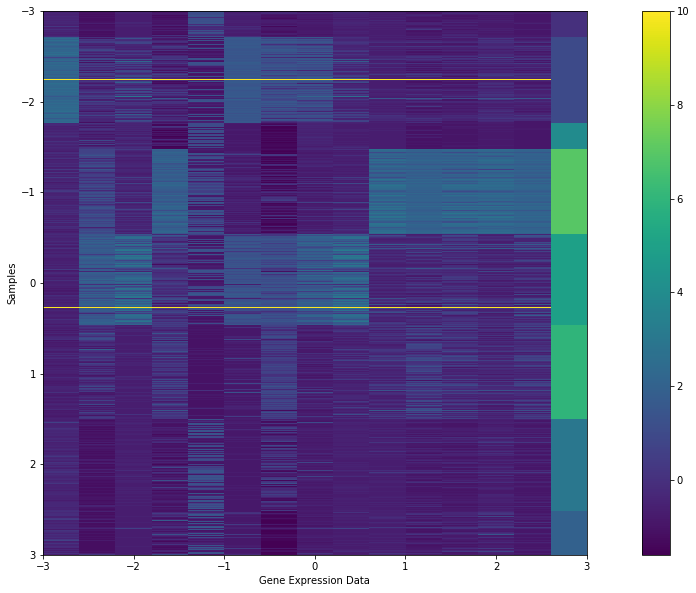

ENSG00000186081,ENSG00000186832 31


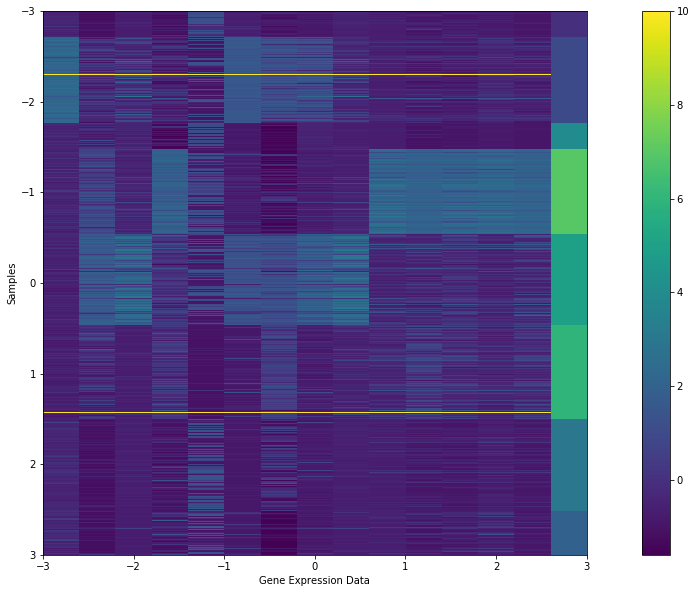

ENSG00000186847,ENSG00000128422 13


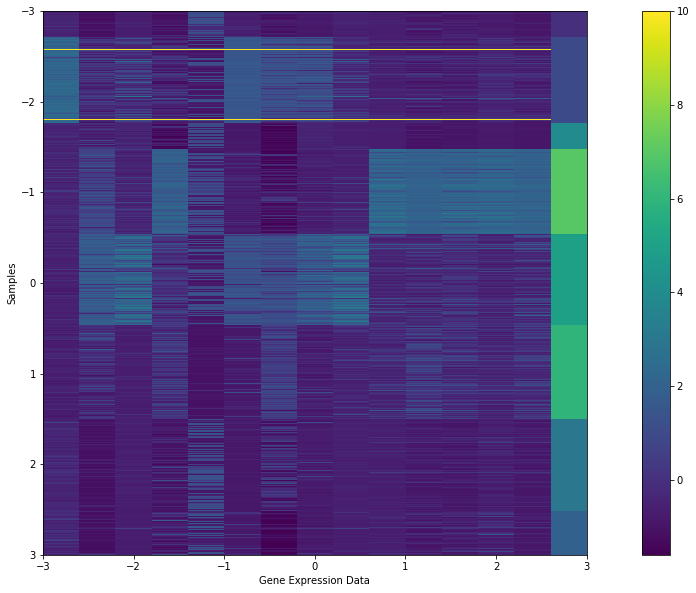

ENSG00000128422,ENSG00000186832 20


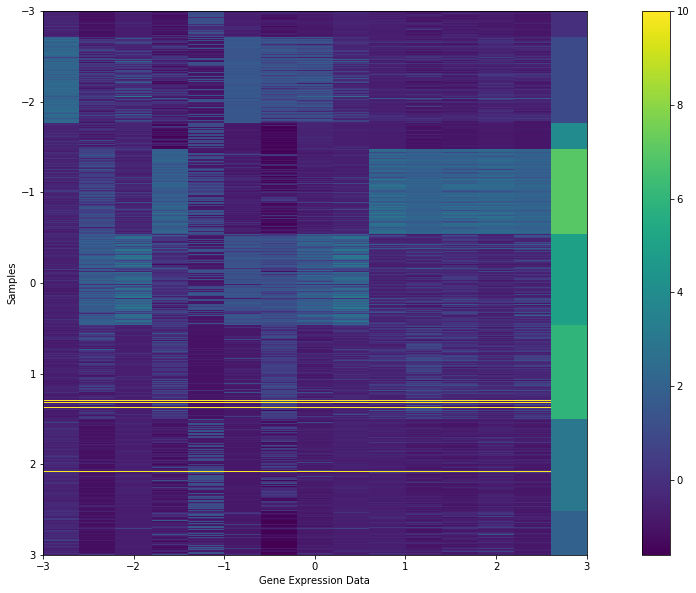

ENSG00000122852,ENSG00000185303,ENSG00000168878 638


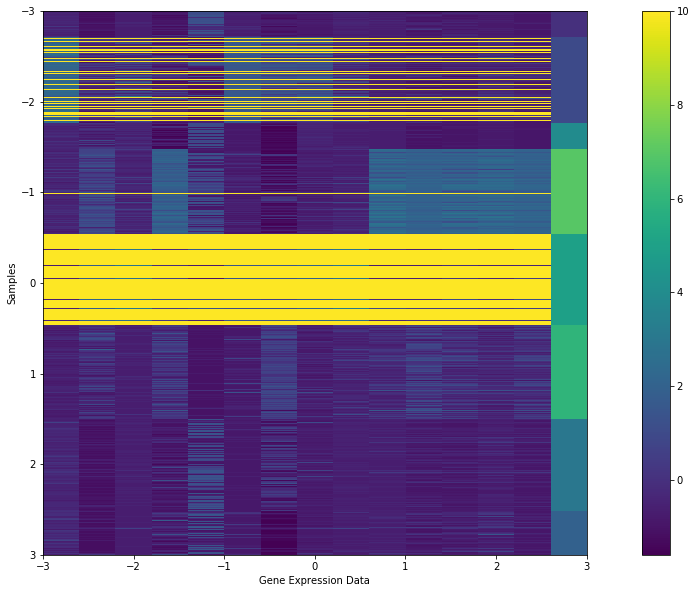

ENSG00000205420,ENSG00000186832,ENSG00000186847,ENSG00000185479 14


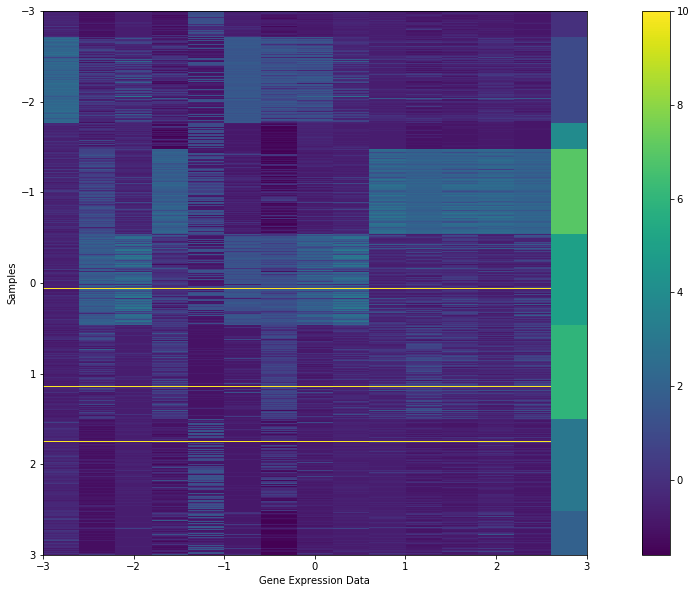

ENSG00000136352,ENSG00000042832 241


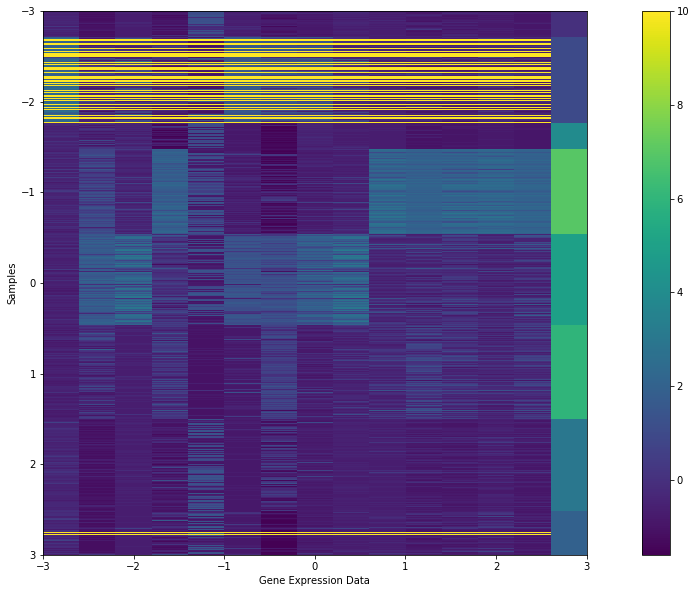

ENSG00000186832,ENSG00000128422,ENSG00000205420 22


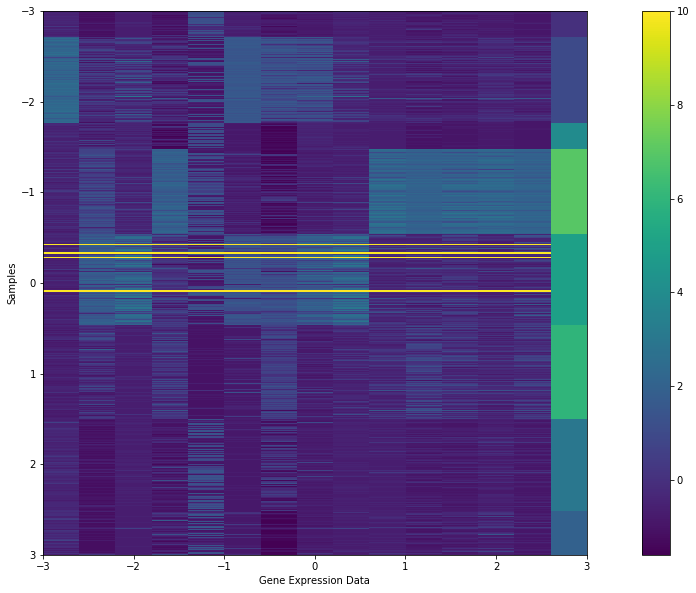

ENSG00000186081,ENSG00000128422,ENSG00000186847 34


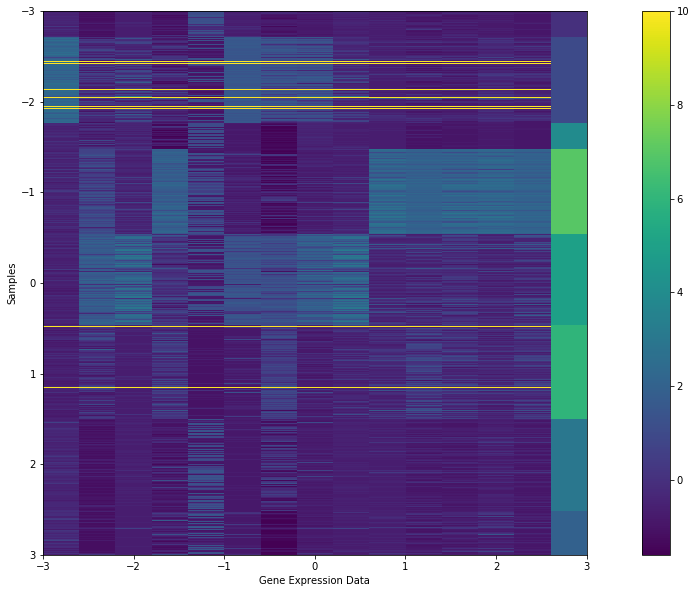

ENSG00000136352,ENSG00000168878 830


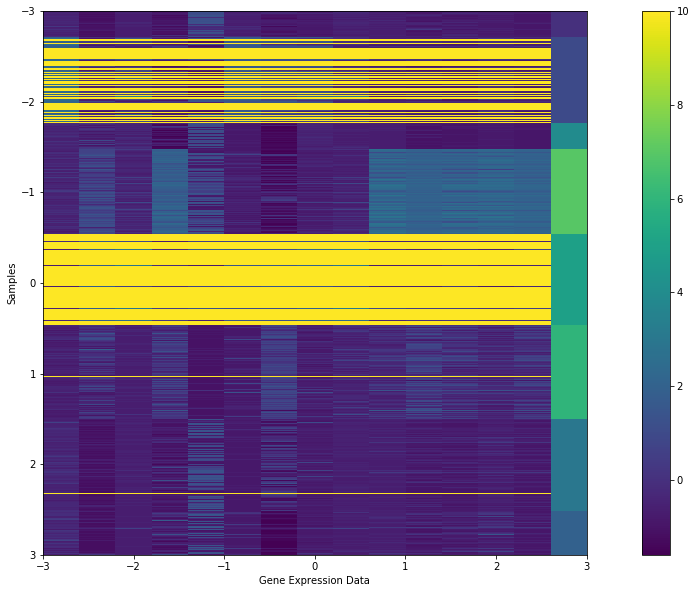

ENSG00000205420,ENSG00000128422 44


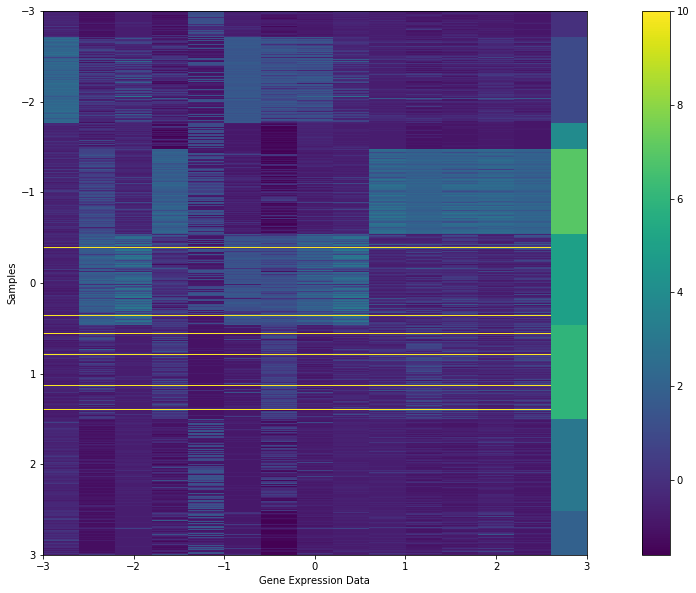

ENSG00000157765,ENSG00000168878 257


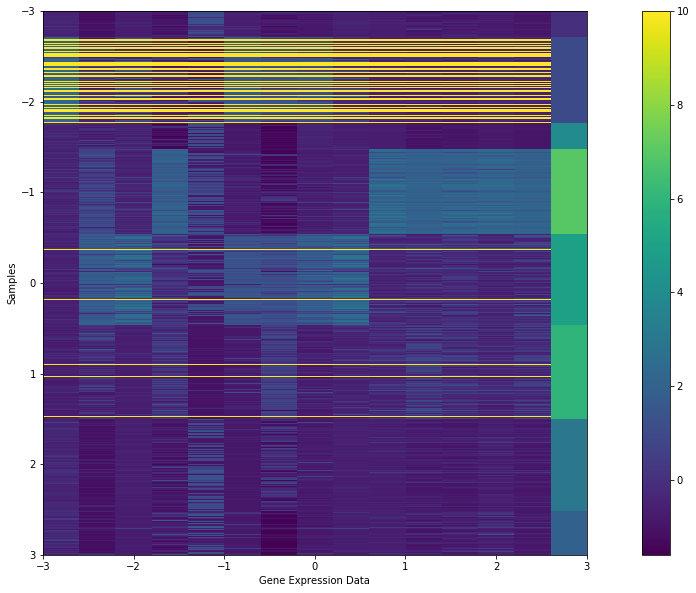

In [30]:
all_labels = list(set(labels))

for key in bicluster_dict.keys():
    if len(bicluster_dict[key]) > 10:
        print(key, len(bicluster_dict[key]))
        df2 = df.copy()
        indices = list(filter(lambda x : x < len(df2), bicluster_dict[key]))
        df2.iloc[indices, :] = 10
        df2["label"] = [all_labels.index(x) for x in labels]
        plt.figure(figsize=(20,10))
        im = plt.imshow(df2, extent=(-3, 3, 3, -3))
        plt.ylabel("Samples")
        plt.xlabel("Gene Expression Data")
        plt.colorbar(im)
        plt.show()

In [31]:
import requests

gene_to_name = {}
for cluster_genes in bicluster_dict.keys():
    genes = cluster_genes.split(',')
    for gene1 in genes:
        if gene1 not in gene_to_name:
            gene_to_name[gene1] = requests.get('http://string-db.org/api/json/resolveList?identifiers={}&species=9606'.format(gene1)).json()[0]["preferredName"]
gene_to_name

{'ENSG00000042832': 'TG',
 'ENSG00000122852': 'SFTPA1',
 'ENSG00000128422': 'KRT17',
 'ENSG00000136352': 'NKX2-1',
 'ENSG00000157765': 'SLC34A2',
 'ENSG00000168878': 'SFTPB',
 'ENSG00000185303': 'SFTPA2',
 'ENSG00000185479': 'KRT6B',
 'ENSG00000186081': 'KRT5',
 'ENSG00000186832': 'KRT16',
 'ENSG00000186847': 'KRT14',
 'ENSG00000205420': 'KRT6A'}

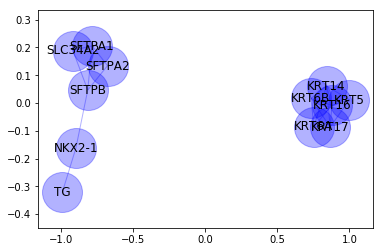

In [32]:
def draw_graph(labels=None, graph_layout='spring',
               node_size=1600, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):

    G=nx.Graph()

    for cluster_genes in bicluster_dict.keys():
        genes = cluster_genes.split(',')
        for gene1 in genes:
            for gene2 in genes:
                G.add_edge(gene_to_name[gene1], gene_to_name[gene2])

    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)
    plt.show()
    return G
G = draw_graph()

In [33]:
from networkx.readwrite.gml import write_gml
write_gml(G, "testgraph.gml")

In [34]:
G2 = nx.Graph()
for node_index, node_neighbors in enumerate(NEIGHBORS):
    for node_neighbor in node_neighbors:
        G2.add_edge(node_index+1, node_neighbor)

In [35]:
write_gml(G2, "neighbors.gml")

In [36]:
len(NEIGHBORS)

3204